# 2D Acoustic Wave
---
- Model Setup: [this link](https://github.com/devitocodes/devito/blob/master/examples/seismic/tutorials/01_modelling.ipynb)

- target: $c(x, z)^2$.

- rescaling: $x' = x/1000, z' = z/1000, t' = t/1000$.

---

# Direct Problem only,  without Source;

# Full Snapshots

# Exact velocity field

# target: learn the forward model and try to reduce residue error

In [1]:
NAME = "0727_full_snapshots_and_velocity_dirichlet"

In [2]:
import jax, jax.nn
from jax import random
import jax.numpy as jnp
from jax.experimental import optimizers

import sys, os
sys.path.append("../../")
	
from Seismic_wave_inversion_PINN.data_utils import *

from collections import namedtuple

In [10]:
def siren_layer_params(key, scale, m, n):
	w_key, b_key = random.split(key)
	return random.uniform(w_key, (m, n), jnp.float32, minval = -scale, maxval = scale), jnp.zeros((n, ), jnp.float32)

def init_siren_params(key, layers, c, w0):
	keys = random.split(key, len(layers))
	return [siren_layer_params(keys[0], w0*jnp.sqrt(c/layers[0]), layers[0], layers[1])] + \
			[siren_layer_params(k, jnp.sqrt(c/m), m, n) for m, n, k in zip(layers[1:-1], layers[2:], keys[1:])]

layers = [3, 32, 32, 32, 32, 32, 32, 32, 32, 1] # (x, z, t) -> p
c0 = 1.0
w0 = 10.0
lambda_0 = 1e-10
direct_params = init_siren_params(random.PRNGKey(0), layers, c0, w0)

# direct_iteration = 100000
# direct_params = np.load("models/{}/iteration_{}/params.npy".format(NAME, direct_iteration), allow_pickle=True)
# direct_params = [[jnp.asarray(arr) for arr in Arr] for Arr in direct_params]

@jax.jit
def scalar_direct_model(params, x, z, t):
	x_ = jnp.hstack([x, z, t])
	for w, b in params[:-1]:
		x_ = jnp.sin(jnp.dot(x_, w) + b)
	return jnp.sum(jnp.dot(x_, params[-1][0]) + params[-1][1])


from jax import lax

@jax.jit
def scalar_inverse_model(x, z): # scaled to [-1, 1]
	return lax.cond(z[0] >= 0.0, z, lambda z: z*0+2.5, z, lambda z: z*0+1.5)

direct_model = jax.jit(jax.vmap(scalar_direct_model, in_axes = (None, 0, 0, 0)))
inverse_model = jax.jit(jax.vmap(scalar_inverse_model, in_axes = (0, 0)))

In [11]:
@jax.jit
def mse(pred, true):
	return jnp.mean(jnp.square(pred - true))

@jax.jit
def l2_regularization(params, lambda_0):
	res = 0
	for p in params:
		res += jnp.sum(jnp.square(p[0]))
	return res*lambda_0

@jax.jit
def scalar_dp_dx(params, x, z, t):
    return jnp.sum(jax.grad(scalar_direct_model, 1)(params, x, z, t))

@jax.jit
def scalar_dp_dz(params, x, z, t):
    return jnp.sum(jax.grad(scalar_direct_model, 2)(params, x, z, t))

@jax.jit
def scalar_dp_dt(params, x, z, t):
    return jnp.sum(jax.grad(scalar_direct_model, 3)(params, x, z, t))

@jax.jit
def dp_dxx(params, x, z, t):
    return jax.grad(scalar_dp_dx, 1)(params, x, z, t)

@jax.jit
def dp_dzz(params, x, z, t):
    return jax.grad(scalar_dp_dz, 2)(params, x, z, t)

@jax.jit
def dp_dtt(params, x, z, t):
    return jax.grad(scalar_dp_dt, 3)(params, x, z, t)

@jax.jit
def loss_fn_(params, batch):
	collocation, dirichlet = batch["collocation"], batch["dirichlet"]
	direct_params = params
    
# 	c = inverse_model(collocation.x, collocation.z)
# 	dp_dtt_ = dp_dtt(direct_params, collocation.x, collocation.z, collocation.t)
# 	dp_dxx_ = dp_dxx(direct_params, collocation.x, collocation.z, collocation.t)
# 	dp_dzz_ = dp_dzz(direct_params, collocation.x, collocation.z, collocation.t)
	p_pred = direct_model(direct_params, dirichlet.x, dirichlet.z, dirichlet.t).reshape((-1, 1))
	
# 	loss_c = mse(dp_dtt_ - c**2*(dp_dxx_ + dp_dzz_), 0)
	loss_d = mse(p_pred, dirichlet.p)
# 	return loss_c, loss_d
	return loss_d

@jax.jit
def loss_fn(params, batch):
	loss_d = loss_fn_(params, batch)
	return batch["Weights"]["d"]*loss_d + l2_regularization(params[0], lambda_0)
# 	loss_c, loss_d = loss_fn_(params, batch)
# 	return batch["Weights"]["c"]*loss_c + batch["Weights"]["d"]*loss_d + l2_regularization(params[0], lambda_0)

@jax.jit
def step(i, opt_state, batch):
	params = get_params(opt_state)
	grad = jax.grad(loss_fn, 0)(params, batch)
	return opt_update(i, grad, opt_state)

@jax.jit
def evaluate(params, batch):
	loss_d = loss_fn_(params, batch)
	return batch["Weights"]["d"]*loss_d, loss_d
# 	loss_c, loss_d = loss_fn_(params, batch)
# 	return batch["Weights"]["c"]*loss_c + batch["Weights"]["d"]*loss_d, loss_c, loss_d


In [12]:
import pickle 
with open("dataset_single_source.pkl", "rb") as file:
	x, z, t, p = pickle.load(file)
	
tzx = tensor_grid([t, z, x])
x, z, t = tzx[:, 2:3], tzx[:, 1:2], tzx[:, 0:1]
p = p.reshape((-1, 1))

dataset_Dirichlet = namedtuple("dataset_Dirichlet", ["x", "z", "t", "p"])
dirichlet = dataset_Dirichlet(*map(lambda x: jnp.array(x), [x, z, t, p]))


class Batch_Generator:
	def __init__(self, key, dataset, batch_size):
		self.key = key
		self.dataset = dataset
		self.batch_size = batch_size
		self.index = jnp.arange(dataset[0].shape[0])
		self.pointer = 0
		self._shuffle()
		
	def _shuffle(self):
		key, subkey = random.split(self.key)
		self.index = random.permutation(subkey, jnp.arange(self.dataset[0].shape[0]))
		self.key = key
		
	def __iter__(self):
		return self
	
	def __next__(self):
		if self.pointer >= len(self.index):
			self._shuffle()
			self.pointer = 0
		self.pointer += self.batch_size
		index_ = self.index[self.pointer-self.batch_size:self.pointer]
		return [d[index_, :] for d in self.dataset]

In [13]:
lr = 1e-3
start_iteration = 0
iterations = 100000
print_every = 1000
save_every = 10000
batch_size_collocation = 10000
batch_size_dirichlet = 10000
w_c = 1.0
w_d = 100.0

key = random.PRNGKey(1)
Dirichlet = Batch_Generator(key, dirichlet, batch_size_dirichlet)
params = direct_params

opt_init, opt_update, get_params = optimizers.adam(lr)
opt_state = opt_init(params)
for iteration in range(start_iteration+1, start_iteration+iterations+1):
	diri = dataset_Dirichlet(*next(Dirichlet))
	collo = diri
	batch = {
		"dirichlet": diri,
		"collocation": collo,
		"Weights": {"c": w_c, "d": w_d}
	}
	opt_state = step(iteration, opt_state, batch)
	if (iteration-start_iteration) % print_every == 0:
		names = ["Loss", "d"]
		params_ = get_params(opt_state)
		losses = evaluate(params_, batch)
		print("{}, Iteration: {}, Train".format(get_time(), iteration) + \
			  ','.join([" {}: {:.4e}".format(name, loss) for name, loss in zip(names, losses)]))
	if (iteration-start_iteration) % save_every == 0:
		params_ = np.asarray(get_params(opt_state), dtype = object)
		save_path = "models/{}/iteration_{}/params.npy".format(NAME, iteration)
		if not os.path.exists(os.path.dirname(save_path)):
			os.makedirs(os.path.dirname(save_path))
		np.save(save_path, params_)

2020/07/31, 06:42:32, Iteration: 1000, Train Loss: 4.8019e+01, d: 4.8019e-01
2020/07/31, 06:42:37, Iteration: 2000, Train Loss: 2.7862e+01, d: 2.7862e-01
2020/07/31, 06:42:42, Iteration: 3000, Train Loss: 2.1932e+01, d: 2.1932e-01
2020/07/31, 06:42:47, Iteration: 4000, Train Loss: 1.9856e+01, d: 1.9856e-01
2020/07/31, 06:42:52, Iteration: 5000, Train Loss: 1.6409e+01, d: 1.6409e-01
2020/07/31, 06:42:56, Iteration: 6000, Train Loss: 1.4531e+01, d: 1.4531e-01
2020/07/31, 06:43:01, Iteration: 7000, Train Loss: 1.3174e+01, d: 1.3174e-01
2020/07/31, 06:43:06, Iteration: 8000, Train Loss: 1.2378e+01, d: 1.2378e-01
2020/07/31, 06:43:11, Iteration: 9000, Train Loss: 1.1194e+01, d: 1.1194e-01
2020/07/31, 06:43:16, Iteration: 10000, Train Loss: 9.5280e+00, d: 9.5280e-02
2020/07/31, 06:43:21, Iteration: 11000, Train Loss: 8.4048e+00, d: 8.4048e-02
2020/07/31, 06:43:26, Iteration: 12000, Train Loss: 7.8652e+00, d: 7.8652e-02
2020/07/31, 06:43:31, Iteration: 13000, Train Loss: 6.6306e+00, d: 6.6306

In [15]:
iterations = 900000
start_iteration = 100000
print_every = 1000
save_every = 100000

for iteration in range(start_iteration+1, start_iteration+iterations+1):
	diri = dataset_Dirichlet(*next(Dirichlet))
	collo = diri
	batch = {
		"dirichlet": diri,
		"collocation": collo,
		"Weights": {"c": w_c, "d": w_d}
	}
	opt_state = step(iteration, opt_state, batch)
	if (iteration-start_iteration) % print_every == 0:
		names = ["Loss", "d"]
		params_ = get_params(opt_state)
		losses = evaluate(params_, batch)
		print("{}, Iteration: {}, Train".format(get_time(), iteration) + \
			  ','.join([" {}: {:.4e}".format(name, loss) for name, loss in zip(names, losses)]))
	if (iteration-start_iteration) % save_every == 0:
		params_ = np.asarray(get_params(opt_state), dtype = object)
		save_path = "models/{}/iteration_{}/params.npy".format(NAME, iteration)
		if not os.path.exists(os.path.dirname(save_path)):
			os.makedirs(os.path.dirname(save_path))
		np.save(save_path, params_)

2020/07/31, 06:52:27, Iteration: 101000, Train Loss: 5.9452e-01, d: 5.9452e-03
2020/07/31, 06:52:32, Iteration: 102000, Train Loss: 5.3816e-01, d: 5.3816e-03
2020/07/31, 06:52:37, Iteration: 103000, Train Loss: 5.3403e-01, d: 5.3403e-03
2020/07/31, 06:52:42, Iteration: 104000, Train Loss: 5.5690e-01, d: 5.5690e-03
2020/07/31, 06:52:47, Iteration: 105000, Train Loss: 5.2776e-01, d: 5.2776e-03
2020/07/31, 06:52:53, Iteration: 106000, Train Loss: 4.7546e-01, d: 4.7546e-03
2020/07/31, 06:52:59, Iteration: 107000, Train Loss: 4.9811e-01, d: 4.9811e-03
2020/07/31, 06:53:04, Iteration: 108000, Train Loss: 4.8303e-01, d: 4.8303e-03
2020/07/31, 06:53:10, Iteration: 109000, Train Loss: 5.7285e-01, d: 5.7285e-03
2020/07/31, 06:53:15, Iteration: 110000, Train Loss: 4.7963e-01, d: 4.7963e-03
2020/07/31, 06:53:20, Iteration: 111000, Train Loss: 4.6148e-01, d: 4.6148e-03
2020/07/31, 06:53:26, Iteration: 112000, Train Loss: 4.6984e-01, d: 4.6984e-03
2020/07/31, 06:53:31, Iteration: 113000, Train Loss:

2020/07/31, 07:01:33, Iteration: 205000, Train Loss: 2.7720e-01, d: 2.7720e-03
2020/07/31, 07:01:38, Iteration: 206000, Train Loss: 2.7126e-01, d: 2.7126e-03
2020/07/31, 07:01:44, Iteration: 207000, Train Loss: 2.7188e-01, d: 2.7188e-03
2020/07/31, 07:01:49, Iteration: 208000, Train Loss: 2.6842e-01, d: 2.6842e-03
2020/07/31, 07:01:54, Iteration: 209000, Train Loss: 2.7482e-01, d: 2.7482e-03
2020/07/31, 07:01:59, Iteration: 210000, Train Loss: 2.9482e-01, d: 2.9482e-03
2020/07/31, 07:02:05, Iteration: 211000, Train Loss: 2.8529e-01, d: 2.8529e-03
2020/07/31, 07:02:10, Iteration: 212000, Train Loss: 2.5919e-01, d: 2.5919e-03
2020/07/31, 07:02:15, Iteration: 213000, Train Loss: 2.7623e-01, d: 2.7623e-03
2020/07/31, 07:02:21, Iteration: 214000, Train Loss: 2.9610e-01, d: 2.9610e-03
2020/07/31, 07:02:26, Iteration: 215000, Train Loss: 2.8060e-01, d: 2.8060e-03
2020/07/31, 07:02:31, Iteration: 216000, Train Loss: 2.6205e-01, d: 2.6205e-03
2020/07/31, 07:02:36, Iteration: 217000, Train Loss:

2020/07/31, 07:10:39, Iteration: 309000, Train Loss: 1.8230e-01, d: 1.8230e-03
2020/07/31, 07:10:44, Iteration: 310000, Train Loss: 2.0258e-01, d: 2.0258e-03
2020/07/31, 07:10:49, Iteration: 311000, Train Loss: 2.0835e-01, d: 2.0835e-03
2020/07/31, 07:10:54, Iteration: 312000, Train Loss: 2.6819e-01, d: 2.6819e-03
2020/07/31, 07:10:59, Iteration: 313000, Train Loss: 1.9004e-01, d: 1.9004e-03
2020/07/31, 07:11:04, Iteration: 314000, Train Loss: 1.9961e-01, d: 1.9961e-03
2020/07/31, 07:11:09, Iteration: 315000, Train Loss: 2.1652e-01, d: 2.1652e-03
2020/07/31, 07:11:14, Iteration: 316000, Train Loss: 2.2356e-01, d: 2.2356e-03
2020/07/31, 07:11:19, Iteration: 317000, Train Loss: 2.2090e-01, d: 2.2090e-03
2020/07/31, 07:11:24, Iteration: 318000, Train Loss: 2.1366e-01, d: 2.1366e-03
2020/07/31, 07:11:29, Iteration: 319000, Train Loss: 2.4722e-01, d: 2.4722e-03
2020/07/31, 07:11:34, Iteration: 320000, Train Loss: 2.1423e-01, d: 2.1423e-03
2020/07/31, 07:11:39, Iteration: 321000, Train Loss:

2020/07/31, 07:21:15, Iteration: 413000, Train Loss: 1.7756e-01, d: 1.7756e-03
2020/07/31, 07:21:22, Iteration: 414000, Train Loss: 1.7206e-01, d: 1.7206e-03
2020/07/31, 07:21:28, Iteration: 415000, Train Loss: 1.7458e-01, d: 1.7458e-03
2020/07/31, 07:21:35, Iteration: 416000, Train Loss: 1.6756e-01, d: 1.6756e-03
2020/07/31, 07:21:41, Iteration: 417000, Train Loss: 1.7794e-01, d: 1.7794e-03
2020/07/31, 07:21:48, Iteration: 418000, Train Loss: 1.6681e-01, d: 1.6681e-03
2020/07/31, 07:21:54, Iteration: 419000, Train Loss: 1.6730e-01, d: 1.6730e-03
2020/07/31, 07:22:01, Iteration: 420000, Train Loss: 1.6789e-01, d: 1.6789e-03
2020/07/31, 07:22:08, Iteration: 421000, Train Loss: 1.9257e-01, d: 1.9257e-03
2020/07/31, 07:22:14, Iteration: 422000, Train Loss: 1.6292e-01, d: 1.6292e-03
2020/07/31, 07:22:21, Iteration: 423000, Train Loss: 1.7558e-01, d: 1.7558e-03
2020/07/31, 07:22:28, Iteration: 424000, Train Loss: 1.7025e-01, d: 1.7025e-03
2020/07/31, 07:22:35, Iteration: 425000, Train Loss:

2020/07/31, 07:31:21, Iteration: 517000, Train Loss: 1.5210e-01, d: 1.5210e-03
2020/07/31, 07:31:27, Iteration: 518000, Train Loss: 1.5072e-01, d: 1.5072e-03
2020/07/31, 07:31:32, Iteration: 519000, Train Loss: 1.6392e-01, d: 1.6392e-03
2020/07/31, 07:31:37, Iteration: 520000, Train Loss: 1.4328e-01, d: 1.4328e-03
2020/07/31, 07:31:42, Iteration: 521000, Train Loss: 1.5231e-01, d: 1.5231e-03
2020/07/31, 07:31:48, Iteration: 522000, Train Loss: 1.6358e-01, d: 1.6358e-03
2020/07/31, 07:31:53, Iteration: 523000, Train Loss: 1.3370e-01, d: 1.3370e-03
2020/07/31, 07:31:58, Iteration: 524000, Train Loss: 1.4548e-01, d: 1.4548e-03
2020/07/31, 07:32:03, Iteration: 525000, Train Loss: 1.5525e-01, d: 1.5525e-03
2020/07/31, 07:32:09, Iteration: 526000, Train Loss: 1.5300e-01, d: 1.5300e-03
2020/07/31, 07:32:14, Iteration: 527000, Train Loss: 1.4182e-01, d: 1.4182e-03
2020/07/31, 07:32:19, Iteration: 528000, Train Loss: 1.6408e-01, d: 1.6408e-03
2020/07/31, 07:32:24, Iteration: 529000, Train Loss:

2020/07/31, 07:40:16, Iteration: 621000, Train Loss: 1.3733e-01, d: 1.3733e-03
2020/07/31, 07:40:21, Iteration: 622000, Train Loss: 1.2576e-01, d: 1.2576e-03
2020/07/31, 07:40:26, Iteration: 623000, Train Loss: 1.6146e-01, d: 1.6146e-03
2020/07/31, 07:40:31, Iteration: 624000, Train Loss: 1.9540e-01, d: 1.9540e-03
2020/07/31, 07:40:36, Iteration: 625000, Train Loss: 1.6092e-01, d: 1.6092e-03
2020/07/31, 07:40:41, Iteration: 626000, Train Loss: 1.3637e-01, d: 1.3637e-03
2020/07/31, 07:40:46, Iteration: 627000, Train Loss: 1.9923e-01, d: 1.9923e-03
2020/07/31, 07:40:51, Iteration: 628000, Train Loss: 1.4759e-01, d: 1.4759e-03
2020/07/31, 07:40:56, Iteration: 629000, Train Loss: 1.9044e-01, d: 1.9044e-03
2020/07/31, 07:41:01, Iteration: 630000, Train Loss: 1.6021e-01, d: 1.6021e-03
2020/07/31, 07:41:06, Iteration: 631000, Train Loss: 1.4913e-01, d: 1.4913e-03
2020/07/31, 07:41:11, Iteration: 632000, Train Loss: 1.2576e-01, d: 1.2576e-03
2020/07/31, 07:41:16, Iteration: 633000, Train Loss:

2020/07/31, 07:48:57, Iteration: 725000, Train Loss: 1.5532e-01, d: 1.5532e-03
2020/07/31, 07:49:03, Iteration: 726000, Train Loss: 1.7072e-01, d: 1.7072e-03
2020/07/31, 07:49:08, Iteration: 727000, Train Loss: 1.6263e-01, d: 1.6263e-03
2020/07/31, 07:49:14, Iteration: 728000, Train Loss: 1.2829e-01, d: 1.2829e-03
2020/07/31, 07:49:20, Iteration: 729000, Train Loss: 1.5434e-01, d: 1.5434e-03
2020/07/31, 07:49:25, Iteration: 730000, Train Loss: 1.3174e-01, d: 1.3174e-03
2020/07/31, 07:49:31, Iteration: 731000, Train Loss: 1.4415e-01, d: 1.4415e-03
2020/07/31, 07:49:36, Iteration: 732000, Train Loss: 1.5506e-01, d: 1.5506e-03
2020/07/31, 07:49:42, Iteration: 733000, Train Loss: 1.1392e-01, d: 1.1392e-03
2020/07/31, 07:49:47, Iteration: 734000, Train Loss: 2.0292e-01, d: 2.0292e-03
2020/07/31, 07:49:53, Iteration: 735000, Train Loss: 1.4221e-01, d: 1.4221e-03
2020/07/31, 07:49:59, Iteration: 736000, Train Loss: 1.7635e-01, d: 1.7635e-03
2020/07/31, 07:50:05, Iteration: 737000, Train Loss:

2020/07/31, 07:57:58, Iteration: 829000, Train Loss: 1.1385e-01, d: 1.1385e-03
2020/07/31, 07:58:04, Iteration: 830000, Train Loss: 1.2818e-01, d: 1.2818e-03
2020/07/31, 07:58:09, Iteration: 831000, Train Loss: 1.5535e-01, d: 1.5535e-03
2020/07/31, 07:58:14, Iteration: 832000, Train Loss: 1.2178e-01, d: 1.2178e-03
2020/07/31, 07:58:19, Iteration: 833000, Train Loss: 1.2554e-01, d: 1.2554e-03
2020/07/31, 07:58:24, Iteration: 834000, Train Loss: 1.1001e-01, d: 1.1001e-03
2020/07/31, 07:58:30, Iteration: 835000, Train Loss: 1.2509e-01, d: 1.2509e-03
2020/07/31, 07:58:35, Iteration: 836000, Train Loss: 1.1880e-01, d: 1.1880e-03
2020/07/31, 07:58:40, Iteration: 837000, Train Loss: 1.5322e-01, d: 1.5322e-03
2020/07/31, 07:58:45, Iteration: 838000, Train Loss: 2.2976e-01, d: 2.2976e-03
2020/07/31, 07:58:50, Iteration: 839000, Train Loss: 1.1742e-01, d: 1.1742e-03
2020/07/31, 07:58:56, Iteration: 840000, Train Loss: 1.1648e-01, d: 1.1648e-03
2020/07/31, 07:59:01, Iteration: 841000, Train Loss:

2020/07/31, 08:07:04, Iteration: 933000, Train Loss: 1.1873e-01, d: 1.1873e-03
2020/07/31, 08:07:09, Iteration: 934000, Train Loss: 1.1374e-01, d: 1.1374e-03
2020/07/31, 08:07:14, Iteration: 935000, Train Loss: 1.1992e-01, d: 1.1992e-03
2020/07/31, 08:07:20, Iteration: 936000, Train Loss: 1.0215e-01, d: 1.0215e-03
2020/07/31, 08:07:25, Iteration: 937000, Train Loss: 1.2177e-01, d: 1.2177e-03
2020/07/31, 08:07:30, Iteration: 938000, Train Loss: 1.6622e-01, d: 1.6622e-03
2020/07/31, 08:07:35, Iteration: 939000, Train Loss: 1.1054e-01, d: 1.1054e-03
2020/07/31, 08:07:41, Iteration: 940000, Train Loss: 1.2219e-01, d: 1.2219e-03
2020/07/31, 08:07:46, Iteration: 941000, Train Loss: 1.0644e-01, d: 1.0644e-03
2020/07/31, 08:07:51, Iteration: 942000, Train Loss: 1.0951e-01, d: 1.0951e-03
2020/07/31, 08:07:56, Iteration: 943000, Train Loss: 1.1184e-01, d: 1.1184e-03
2020/07/31, 08:08:02, Iteration: 944000, Train Loss: 1.2400e-01, d: 1.2400e-03
2020/07/31, 08:08:07, Iteration: 945000, Train Loss:

In [20]:
import pickle 
with open("dataset_single_source.pkl", "rb") as file:
	x, z, t, p = pickle.load(file)
	
import matplotlib as mpl
from matplotlib.cm import cool
from matplotlib.colors import Normalize

from mpl_toolkits.axes_grid1 import make_axes_locatable

from matplotlib import pyplot as plt
plt.rcParams.update(plt.rcParamsDefault)

def plot_(t_index):
	tzx_test = tensor_grid([t[t_index], z, x])
	p_pred = direct_model(get_params(opt_state), tzx_test[:, 2:3], tzx_test[:, 1:2], tzx_test[:, 0:1]).reshape((len(z), len(x)))
	p_true = p[t_index, :].reshape((len(z), len(x)))

	cmap = cool
	norm = Normalize(vmin=-10, vmax=10)

	X, Z = np.meshgrid(x, z)
	fig, ax = plt.subplots(1, 3, figsize = (15, 5))
	fig.subplots_adjust(right = 1.0)

	im0 = ax[0].contourf(X, Z, p_true, cmap = cmap, norm = norm, levels = 1000)
	ax[0].set_title("true")
	divider = make_axes_locatable(ax[0])
	cax = divider.append_axes('right', size='5%', pad=0.05)
	mpl.colorbar.ColorbarBase(cax, cmap = cmap, norm = norm, orientation='vertical')

	# norm = mpl.colors.Normalize(vmin=1.0, vmax=3.0)
	im1 = ax[1].contourf(X, Z, p_pred, cmap = cmap, norm = norm, levels = 1000)
	ax[1].set_title("pred")
	divider = make_axes_locatable(ax[1])
	cax = divider.append_axes('right', size='5%', pad=0.05)
	mpl.colorbar.ColorbarBase(cax, cmap = cmap, norm = norm, orientation='vertical')

	norm = mpl.colors.Normalize(vmin=-0.2, vmax=0.2)
	im2 = ax[2].contourf(X, Z, p_true - p_pred, cmap = cmap, norm = norm, levels = 1000)
	ax[2].set_title("t = {:.4e}, MSE: {}".format(t[t_index]/2, np.mean(np.square(p_true - p_pred))))
	divider = make_axes_locatable(ax[2])
	cax = divider.append_axes('right', size='5%', pad=0.05)
	mpl.colorbar.ColorbarBase(cax, cmap = cmap, norm = norm, orientation='vertical')

	plt.show()

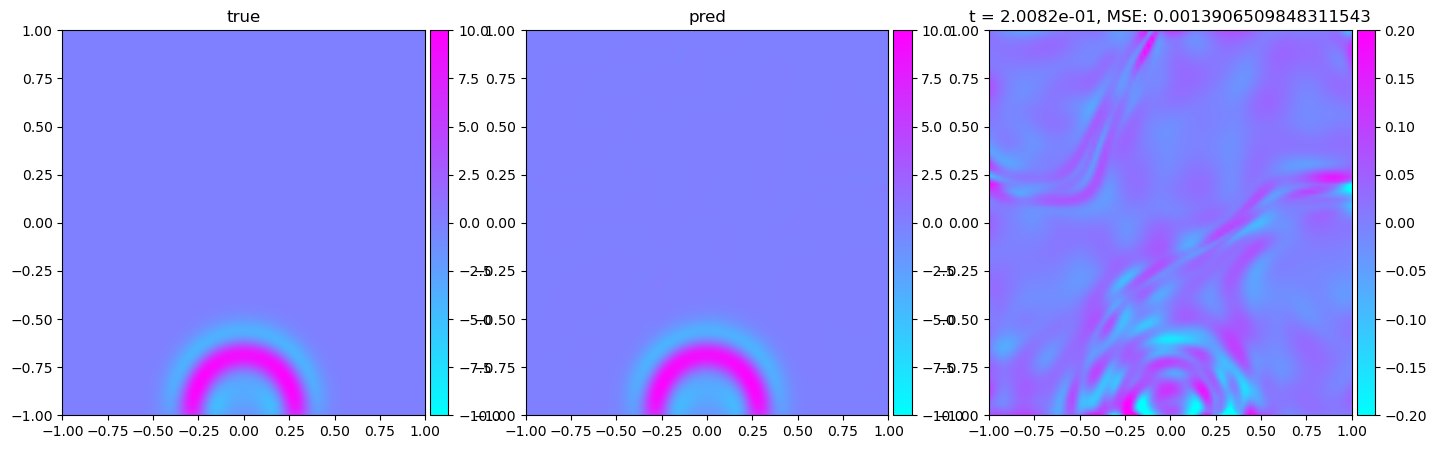

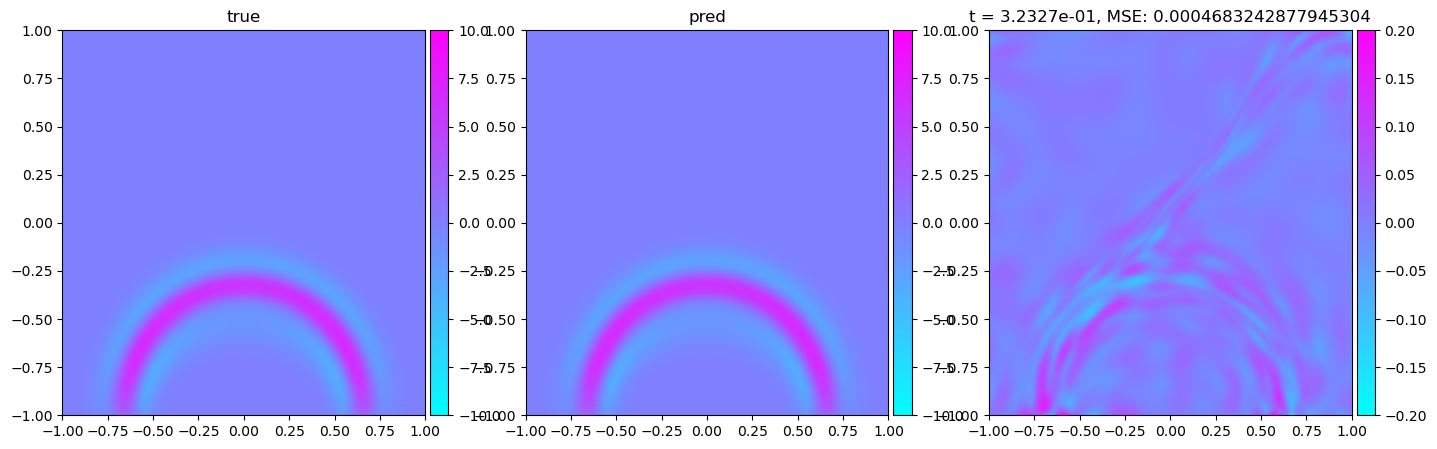

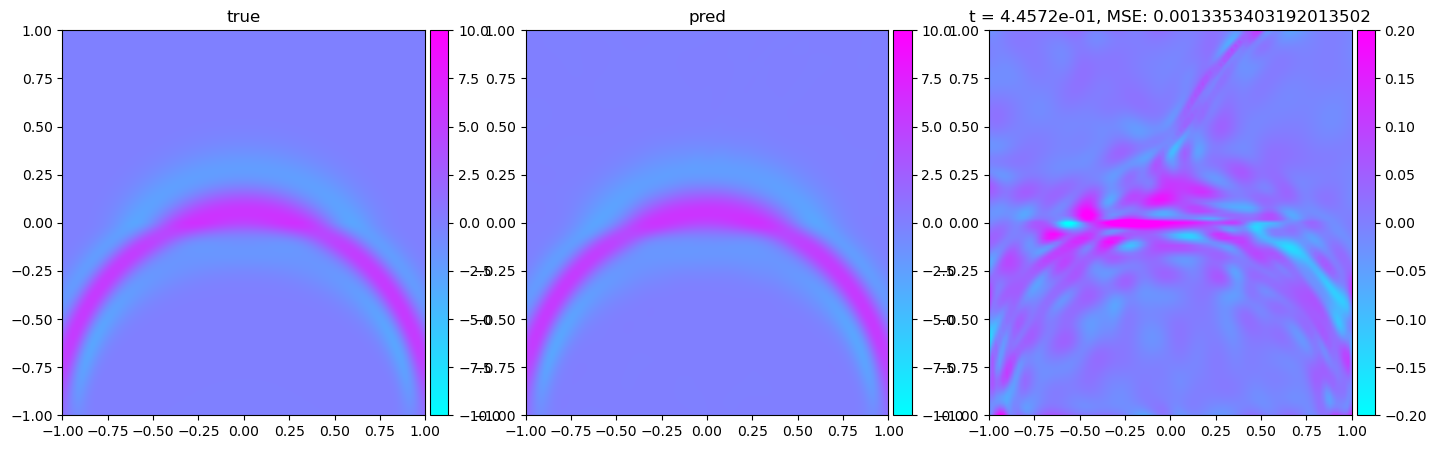

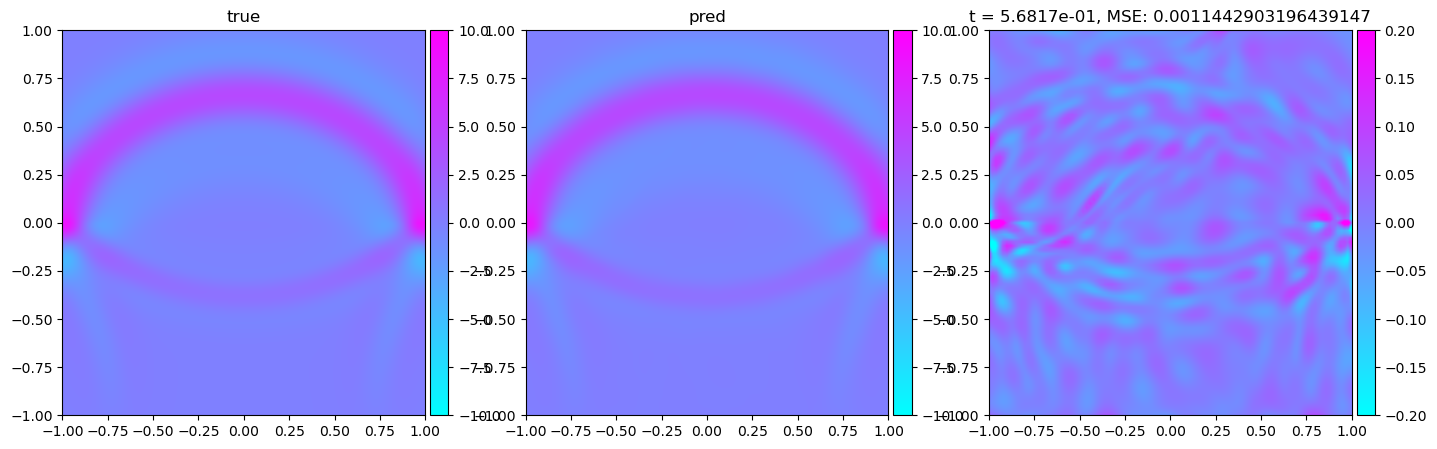

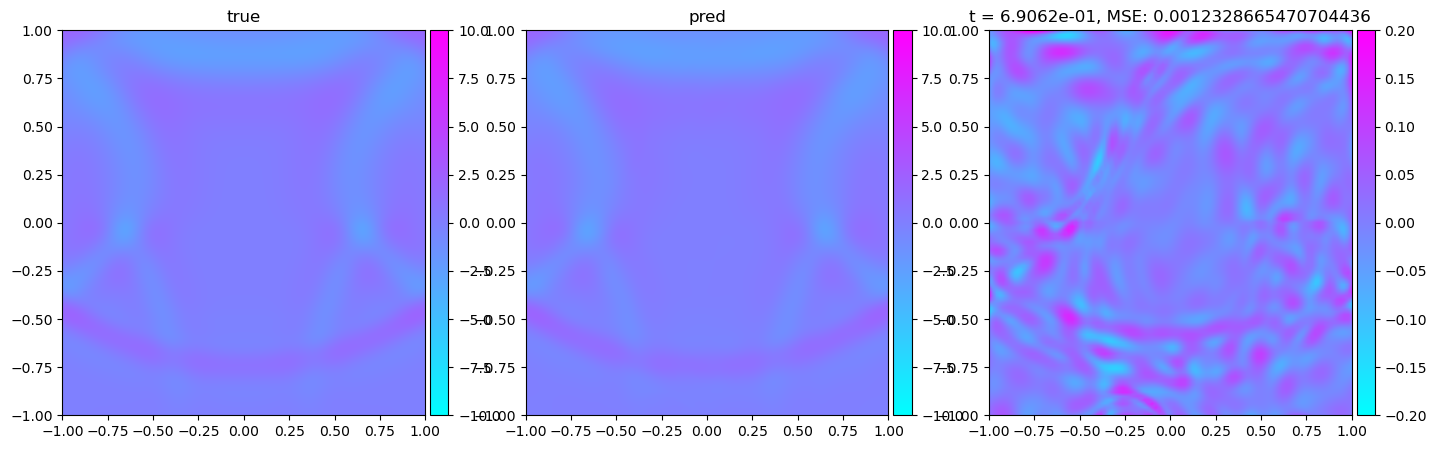

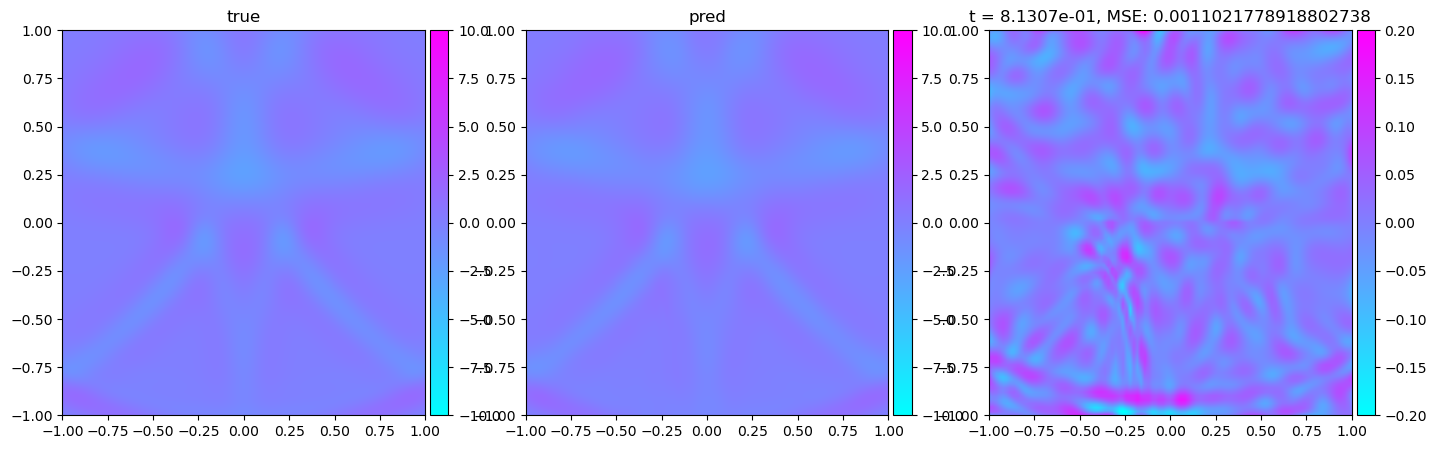

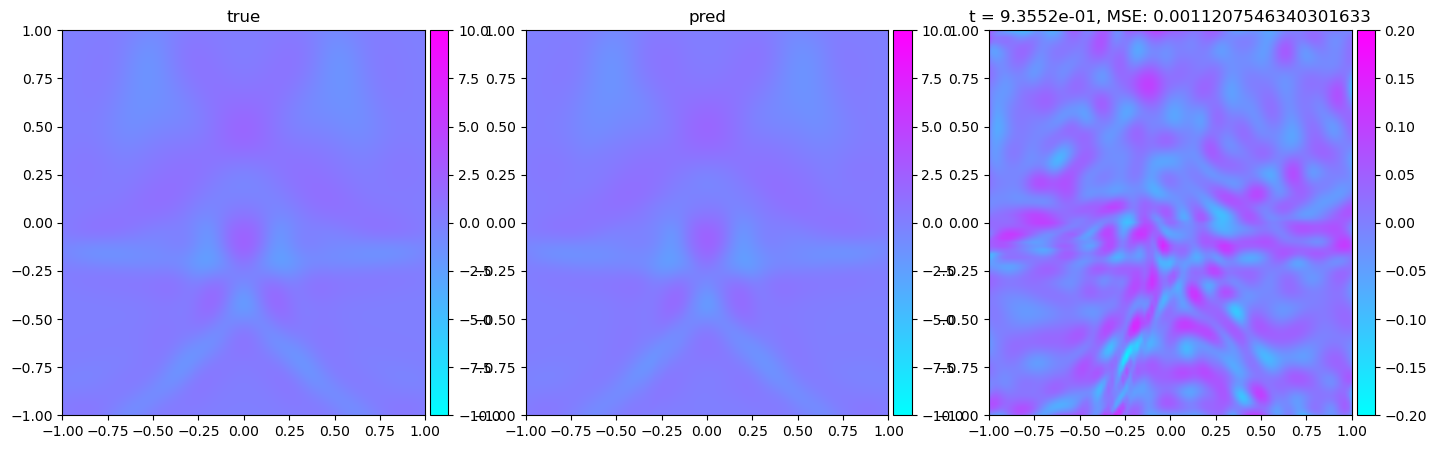

In [21]:
for i in range(0, len(t), 50):
	plot_(i)

In [ ]:
p_